<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

In [1]:
# Check GPU assigned
!nvidia-smi

Tue Jun 29 11:18:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Network, dataset, functions and parameters

### LIBRARIES

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
import random


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix

### Resnet32

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

"""
Credits to @hshustc
Taken from https://github.com/hshustc/CVPR19_Incremental_Learning/tree/master/cifar100-class-incremental
"""

import math
from torch.nn import init
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, use_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.stride = stride
        self.use_relu = use_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.use_relu:
            out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Downsample(nn.Module):
    def __init__(self, nIn, nOut, stride):
        super(Downsample, self).__init__()
        assert stride == 2
        self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)

    def forward(self, x):
        x = self.avg(x)
        return torch.cat((x, x.mul(0)), 1)


class CifarResNet(nn.Module):

    def __init__(self, block=BasicBlock, depth=32, num_classes=0, channels=3):

        super(CifarResNet, self).__init__()

        # Model type specifies number of layers for CIFAR-10 and CIFAR-100 model
        assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
        layer_blocks = (depth - 2) // 6
        bn = nn.BatchNorm2d
        self.inplanes = 16

        self.conv_1_3x3 = nn.Conv2d(channels, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_1 = bn(self.inplanes)

        self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
        self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
        self.stage_3 = self._make_layer(block, 64, layer_blocks, 2, last=True)
        self.avgpool = nn.AvgPool2d(8)
        self.relu = nn.ReLU()
        #self.linear = nn.Linear(64, num_classes)
        self.fcs = nn.ModuleList([nn.Linear(64, num_classes)])

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, math.sqrt(1. / 64.))
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, last=False):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = Downsample(self.
inplanes, planes * block.expansion, stride)

        layers = [block(self.inplanes, planes, stride, downsample)]

        self.inplanes = planes * block.expansion

        if last:
            for i in range(1, blocks - 1):
                layers.append(block(self.inplanes, planes))

            layers.append(block(self.inplanes, planes, use_relu=False))

        else:
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv_1_3x3(x)

        x = self.bn_1(x)
        x = self.relu(x)

        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

    def predict(self, x):
        out = []
        for fc in self.fcs:
            out.append(fc(x))
        out = torch.cat(out, dim=1)
        return out

    def addOutputNodes(self, num_classes):
        self.fcs.append(nn.Linear(64, num_classes))

### Cifar100

In [4]:
# ref:
# https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py
# https://pytorch.org/docs/stable/_modules/torchvision/datasets/cifar.html#CIFAR10
# homework2 (caltech)

from torchvision.datasets import VisionDataset
from PIL import Image

import os
import os.path
import numpy as np
import pandas as pd
import pickle
import random

from torch.autograd import Variable

# This is an handler class for the Cifar dataset
class CIFAR100(VisionDataset):
    """
    `CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR100` Dataset.
    """
    base_folder = 'cifar-100-python'
    train_file = 'train'
    test_file = 'test'
    meta_file = 'meta'

    def __init__(self, root, split = 'train', transform = None):
        """
          Args:
              root (string): Root directory of the dataset where directory
                  cifar-100-python exists.
              split (string, optional): If 'train', creates dataset from training
                  set, otherwise creates from test set.
              transform (callable, optional): A function/transform that takes in a
                  PIL image and returns a transformed version.
        """
        super(CIFAR100, self).__init__(root, transform=transform)

        self.split = split
        if split == 'train':
            filename = self.train_file
        else:
            filename = self.test_file

        data_path = os.path.join(self.root, self.base_folder, filename)
        data = None
        labels = None

        with open(data_path, 'rb') as f:
            entry = pickle.load(f, encoding='latin1')
            data = entry['data']
            labels = entry['fine_labels']
        
        data = np.vstack(data).reshape(-1, 3, 32, 32)
        data = data.transpose((0, 2, 3, 1))  # Convert to HWC
        
        labels = np.array(labels)

        self.df = pd.DataFrame()
        self.df['data'] = pd.Series(list(data))
        self.df['labels'] = labels

        self.data = self.df['data']
        self.labels = self.df['labels']

        self._load_meta()

    def _load_meta(self):
        meta_path = os.path.join(self.root, self.base_folder, self.meta_file)
        with open(meta_path, 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
            self.label_names = meta['fine_label_names']

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.df.loc[index, 'data'], self.df.loc[index, 'labels']

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img) # Return a PIL image

        if self.transform is not None:
            img = self.transform(img)

        return index, img, target
    def __len__(self):
        return len(self.data)


    def getTargets(self):
        return set(self.labels)
     
    # test
    def get_indices(self, labels):
        return list(self.df[self.df['labels'].isin(labels)].index)

    def split_classes(self, n_splits=10, seed=None, dictionary_of='dataframes'):
        if dictionary_of not in ['dataframes','indices']:
            raise ValueError("'dictionary_of' must be equal to 'dataframes' or 'indices'")

        all_classes = list(self.df['labels'].value_counts().index)
        dictionary = {}
        random.seed(seed)
        random.shuffle(all_classes)
        split_size = int(len(all_classes)/n_splits)
        for j in range(n_splits):
            if ((j+1)*split_size < len(all_classes)):
                split_end = (j+1)*split_size
            else:
                split_end = None
            subgroup = all_classes[j*split_size:split_end]
            if dictionary_of == 'dataframes':
                dictionary[j] = self.df[self.df['labels'].isin(subgroup)]
            elif dictionary_of == 'indices':
                dictionary[j] = list(self.df[self.df['labels'].isin(subgroup)].index)
        return dictionary

    def split_groups_in_train_validation(self, groups, ratio=0.5, seed=None):
        groups_train_val = dict()
        for k, subdf in groups.items():
            train_indexes = []
            val_indexes = []
            split_labels = list(subdf['labels'].value_counts().index)
            for l in split_labels:
                indexes_to_sample = list(subdf[subdf['labels'] == l].index)
                random.seed(seed)
                train_samples = random.sample(indexes_to_sample, int(len(indexes_to_sample)*ratio))
                train_indexes = train_indexes + train_samples
                val_indexes = val_indexes + list(set(indexes_to_sample).difference(set(train_samples)))
            groups_train_val[k] = {
                'train': train_indexes,
                'val': val_indexes
            }
        return groups_train_val
    
    def split_in_train_val_groups(self, n_splits=10, ratio=0.5, seed=None):
        groups = self.split_classes(n_splits=n_splits, seed=seed)
        return self.split_groups_in_train_validation(groups, ratio=ratio, seed=seed)

    # given a tensors returns an image (used in exemplars)
    #def tensorToImg(self, tensor):
    #   return Variable(transform(Image.fromarray(img)), volatile=True)


### Reverse Index

In [5]:
import pandas as pd
import numpy as np
import torch

__all__ = ['ReverseIndex']

class ReverseIndex():

    def __init__(self, dataset, splits, device='cuda'):

        self.df = pd.DataFrame(columns=['group', 'labels'])

        for k in splits.keys():
            labels = list(dataset.df.loc[splits[k]['train'],'labels'].value_counts().index)
            group = [k for i in range(len(labels))]
            data = pd.DataFrame(np.array([group, labels]).T, columns=['group', 'labels'])
            self.df = self.df.append(data, ignore_index=True)

        self.df['nodes'] = self.df.index
        self.device = device
    
    def _changeIndex(self, reverse_index, column):
        reverse_index = reverse_index.set_index(column)
        reverse_index[column] = reverse_index.index
        return reverse_index

    def getLabels(self, outputs):
        outs = outputs.cpu().numpy()
        reverse_index = self._changeIndex(self.df, 'nodes')
        labels = reverse_index.loc[outs, 'labels']

        labels = torch.tensor(list(labels))
        return labels.to(self.device)

    def getNodes(self, labels):
        labels = labels.cpu().numpy()
       
        reverse_index = self._changeIndex(self.df, 'labels')

        nodes = reverse_index.loc[labels, 'nodes']

        nodes = torch.tensor(list(nodes))
        return nodes.to(self.device)

    def getGroups(self, distinct=True):
        return self.df['group'].value_counts().index.sort_values()
    
    def getLabelsOfGroup(self, group):
        return self.df.loc[self.df['group'] == group, 'labels']

### utils

In [6]:
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader
import math
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import Module

# These are the default iCaRL hyper-parameters
def getHyperparams():
	dictHyperparams = {
		"LR": 2,
		"MOMENTUM": 0.9,
		"WEIGHT_DECAY": 1e-5,
		"NUM_EPOCHS": 70,
		"MILESTONES": [49, 63],
		"BATCH_SIZE": 128,
		"DEVICE": 'cuda',
		"GAMMA": 0.2,
		"SEED": 66, #use 30, 42, 16
		"LOG_FREQUENCY": 10,
		"NUM_CLASSES": 100
	}
	return dictHyperparams

def getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize):
	optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
	scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1) 
	return optimizer, scheduler

# the mean and the std have been found on the web as mean and std of cifar100
# alternative (realistic): compute mean and std for the dataset
def getTransformations():
	# Define transforms for training phase
	train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
	                                      transforms.Pad(4), # Add padding
	                                      transforms.RandomCrop(32),# Crops a random squares of the image
	                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) 
	])
	# Define transforms for the evaluation phase
	eval_transform = transforms.Compose([
	                                      transforms.ToTensor(),
	                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)) 
	])
	return train_transform, eval_transform

# BCEWithLogits = Sigmoid + BCE, is the loss used in iCaRL
def getLossCriterion():
	criterion = nn.BCEWithLogitsLoss(reduction = 'mean') 
	return criterion

# CrossEntropyLoss 
def computeLoss(criterion, outputs, labels):
	return criterion(outputs, labels)
 
# Loss L2
def l2Loss (outputs, labels):
  criterion = nn.MSELoss()
  return criterion(outputs, labels)

# Loss L1
def l1Loss(outputs, labels):
  criterion = nn.L1Loss()
  return criterion(outputs, labels)

# support BCE
def _one_hot_encode(labels, n_classes, reverse_index, dtype=None, device='cuda'):
	batch_size = len(labels)
	enconded = torch.zeros(batch_size, n_classes, dtype=dtype, device=device)
	labels=map_to_outputs(labels, reverse_index)
	for i, l in enumerate(labels):
	  enconded[i, l] = 1
	return enconded

def map_to_outputs(labels, reverse_index):
	if reverse_index is None:
	  return labels
	if type(labels) == int:
	  return int(reverse_index.getNodes(torch.tensor([labels])))
	elif type(labels) == torch.Tensor:
		return reverse_index.getNodes(labels)


def plotAccuracyTrend(method, data_plot_line, seed):
	plt.figure(figsize=(20,7))
	accuracyDF=pd.DataFrame(data_plot_line, columns = ['Classes','Accuracy'])
	ax = sns.lineplot(x="Classes", y="Accuracy",data=accuracyDF, marker = 'o')
	ax.minorticks_on()
	ax.set_xticks(np.arange(10,110,10))
	ax.set_xlim(xmin=9, xmax=101)
	ax.set_ylim(ymin=0, ymax=1)
	plt.legend(['Accuracy {}'.format(method)])
	ax.grid(axis='y')
	plt.title("Accuracies against seen classes {} - seed: {}".format(method, seed))
	
	filename = "acc_{}_{}.jpg".format(method, seed) # ex. acc_lwf_30
	plt.savefig(filename, format='png', dpi=300)
	plt.show()

def plotConfusionMatrix(method, confusionMatrixData, seed):
	fig,ax=plt.subplots(figsize=(10,10))
	sns.heatmap(confusionMatrixData,cmap='terrain',ax=ax)
	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.title("Confusion Matrix {} - seed: {}".format(method, seed))

	filename = "cm_{}_{}.jpg".format(method, seed) # ex. cm_lwf_30
	plt.savefig(filename, format='png', dpi=300)
	plt.show()

# Write down the metrics (accuracy trand and confusion matrix)
# this method is a shortcut when perfoming multiple tests with different splits (random_seed)
# and allow us to plot on the same graph the data from multiple models (accuracy)
def writeMetrics(method, seed, accuracies, confusionMatrixData):
  data = {}
  data['accuracies'] = []
  data['cm'] = [] #cm line
  i = 0
  for classes_seen in range(10, 110, 10): #x axis on the plot
    data['accuracies'].append({classes_seen : accuracies[i]}) 
    i += 1

  i = 0
  for class_num in range(0,len(confusionMatrixData)): #rows of the cm
    data['cm'].append({class_num : confusionMatrixData[i].tolist()}) 
    i += 1
  
  # dump to file
  aus = method + '_' + str(seed)
  filename = 'data_{}.json'.format(aus)
  with open(filename, 'w') as f:
    json.dump(data, f)

def joinSubsets(dataset, subsets):
    indices = []
    for s in subsets:
        indices += s.indices
    return Subset(dataset, indices)


# Functions
def addOutputs(net, num):
    net.addOutputNodes(num)

def getResNet32():
    net = CifarResNet()
    # net.fc = nn.Linear(net.fc.in_features, output_size) # embedded in the class

    criterion = getLossCriterion()
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return net, criterion, optimizer, scheduler

def addOutputs(net, num):
    net.addOutputNodes(num)

def getNet():
    return getResNet32()

def getSchedulerOptimizer(net):
    parameters_to_optimize = net.parameters()
    optimizer, scheduler = getOptimizerScheduler(LR, MOMENTUM, WEIGHT_DECAY, MILESTONES, GAMMA, parameters_to_optimize)
    return optimizer, scheduler

### DATA

In [7]:
# Download dataset from the official source and save it into DATA/cifar-100-pyhton
DATA_DIR = 'DATA' # here the dataset will be downloaded

if not os.path.isdir('./{}'.format("$DATA_DIR/cifar-100-python")):
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
    !tar -xf 'cifar-100-python.tar.gz'  
    !mkdir $DATA_DIR
    !mv 'cifar-100-python' "$DATA_DIR/cifar-100-python"
    !rm -rf 'cifar-100-python.tar.gz'

--2021-06-29 11:18:05--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  31.7MB/s    in 5.7s    

2021-06-29 11:18:12 (28.1 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

mkdir: cannot create directory ‘DATA’: File exists
mv: cannot move 'cifar-100-python' to 'DATA/cifar-100-python/cifar-100-python': Directory not empty


### HYPERPARAMETERS

In [8]:
DEVICE = 'cuda'
NUM_CLASSES = 100
BATCH_SIZE = 128 
LR = 0.01    
MOMENTUM = 0.9     
WEIGHT_DECAY = 1e-05
NUM_EPOCHS = 30
GAMMA = 0.2
LOG_FREQUENCY = 10
MILESTONES = [49,63]
RANDOM_SEED = 66

### Data preprocessing

In [9]:
train_transform, eval_transform = getTransformations()

### train & test

In [10]:
# Import dataset and apply transformations 
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# Check datasets length 
print(len(train_dataset))
print(len(test_dataset))

50000
10000


### SPLIT DATA IN CLASSES

In [11]:
def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = list(reverse_index.getGroups())
    for g in groups:
        labels_of_groups = reverse_index.getLabelsOfGroup(g)
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

In [12]:
# TRAIN / VAL split
train_splits = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
outputs_labels_mapping = ReverseIndex(train_dataset, train_splits)
print(outputs_labels_mapping)

# TEST split
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

In [13]:
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,10):
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

## Fine tuning

### train, validate, test

In [ ]:
import copy
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10

    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            # # if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            # if (group_id > 1):
            #   old_features = old_net.forward(images)
            #   old_outputs = old_net.predict(old_features)
            #   labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### sequential learning fine tuning

In [ ]:
### Fine tuning
def sequentialLearningFineTuning(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    old_net = None
    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen, group_id, old_net)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    #confusion_matrix(all_labels_cm, all_preds_cm)

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

### execution

In [ ]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningFineTuning(train_subsets, val_subsets, test_subsets)

GROUP:  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Starting epoch 1/70, LR = [0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 0.7173749208450317
Train step - Step 10, Loss 0.31387636065483093
Train step - Step 20, Loss 0.2874338626861572
Train step - Step 30, Loss 0.2654590606689453
Train epoch - Accuracy: 0.318989898989899 Loss: 0.34560690457772725 Corrects: 1579
Starting epoch 2/70, LR = [0.1]
Train step - Step 40, Loss 0.26789265871047974
Train step - Step 50, Loss 0.258944034576416
Train step - Step 60, Loss 0.2350231260061264
Train step - Step 70, Loss 0.23865528404712677
Train epoch - Accuracy: 0.44363636363636366 Loss: 0.24301170718790305 Corrects: 2196
Starting epoch 3/70, LR = [0.1]
Train step - Step 80, Loss 0.23784291744232178
Train step - Step 90, Loss 0.22167158126831055
Train step - Step 100, Loss 0.22836807370185852
Train step - Step 110, Loss 0.21694694459438324
Train epoch - Accuracy: 0.48707070707070704 Loss: 0.22610946089330344 Corrects: 2411
Starting epoch 4/70, LR = [0.1]
Train step - Step 120, Loss 0.21196965873241425
Train step - Step 130, Loss 0.20575585961341

KeyboardInterrupt: ignored

### plot results

In [ ]:
method = "finetuning"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

## LWF

### train, validate, test

In [ ]:
import copy
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10

    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            # if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### sequential learning LWF

In [ ]:
### LWF
def sequentialLearningLWF(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1


    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      train(net, train_loader, criterion, optimizer, scheduler, num_classes_seen, group_id, old_net)

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

### execution

In [ ]:
# train
# net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningLWF(train_subsets, val_subsets, test_subsets)

### plot results

In [ ]:
method = "Learning Without Forgetting"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

In [ ]:
"""num_classes_seen = 100
dif_accuracies=printAccuracyDifference(net,old_accuracies, num_classes_seen)
dif_accuracies"""

## iCaRL

### classify

In [14]:
def classify(batch_img, net, exemplar_sets):
  """ classify images by nearest mean-of-exemplars """ 
  """ 
  class1: list_of_indices for images that represent class1
  class2: list_of_indices for images that represent class2
  ...
  class100: list_of_indices for images that represent class 100
  with Subset I retrieve the images from the train_dataset
  iterate over it to calculate mean for each class
  """
  net.eval()
  classes_mean = []
  for k, exemplars_indices in exemplar_sets.items():
    features = []
    class_images_set = Subset(train_dataset, exemplars_indices)
    class_images = DataLoader(class_images_set, batch_size=BATCH_SIZE, num_workers=2)
    for _, images, labels in class_images:
      # for each class (paper from y=1...t) calculate features and then mean
      feature = net.forward(images)
      features.append(feature)
    features_s = torch.cat(features)
    class_mean = features_s.mean(0)
    classes_mean.append(class_mean)
    means_exemplars = torch.cat(classes_mean, dim=0)
    means_exemplars = torch.stack([means_exemplars] * BATCH_SIZE)
    means_exemplars = means_exemplars.transpose(1,2)
  feature_images_to_classify = net.forward(batch_img)
  # sono da normalizzare?
  feature_images_to_classify = feature_images_to_classify.unsqueeze(2)
  feature_images_to_classify = feature_images_to_classify.expand_as(means_exemplars) # expand_as to get the same dimension
  preds = torch.argmin((feature_images_to_classify - means_exemplars).pow(2).sum(1), dim=1)
  return preds

### construct exemplar set

In [15]:
import sys

def constructExemplarSet(net, Xclass, m):
#Xclass contiene immagini e label della classe X
  exemplars_set = []
  feature_exemplars = []
  indexes = []
  features = [] 
  class_images = []
  net.eval()
  
  with torch.no_grad():
    XtrainLoader = torch.utils.data.DataLoader(Xclass, shuffle = True, batch_size=1, num_workers=2)
    for _, image, labels in XtrainLoader:
      image = image.to(DEVICE)
      class_images.append(image)
      # per ogni immagine della classe x, prendiamo le rispettive feature e le uniamo nel vettore features, che contiene tutte quelle delle immagini della classe x
      feature = net.forward(image)
      #feature = net.predict(featuretmp)
      feature = feature/np.linalg.norm(feature.cpu())
      features.append(feature)

    features = torch.cat(features, dim=0) #cat solve the problem of inequal size of tensors 
    current_class_mean = features.mean(0) # mu = media delle features delle immagini della classe

    for k in range(1, m+1):
      min = 100000
      sum = 0
      for j in range(k-1):
        sum += feature_exemplars[j]
      for x in range(len(Xclass)): 
        if (x not in indexes):
          phiX = features[x]
          val = current_class_mean - ((phiX + sum)/k)
          val = np.linalg.norm(val.cpu().numpy()) ## NORMA 
          if (val < min):
            min = val
            feature_min = phiX
            index_min = x
      feature_exemplars.append(feature_min)
      exemplars_set.append(Xclass[index_min][0])

    print("lunghezza exemplar set: ", len(exemplars_set))
    return exemplars_set

### reduce exemplar set

In [16]:
# DA CHIAMARE PER OGNI CLASSE k: riduce il numero di exemplars all'interno dell'exemplar_set della classe k 
# EXEMPLAR SET è una lista di indici che rappresentano la posizione dell'immagine selezionata per l'exemplar della classe corrente nel dataset di partenza
def reduceExemplarSet(m, exemplars_set):
  exemplars_new = []
  for i in range(m):
    if (exemplars_set != []):
      exemplars_new.append(exemplars_set[i])

  return exemplars_new

### update representation

In [17]:
def updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes, group_id, K, exemplars_set_tot, old_net):
  #exemplars_set_tot contiene tutti gli exemplars set ottenuti fino ad ora
  #train_iter contiene tutti i dati (immagini + labels) delle classi nuove (s, .., t)
  exemplars_subset = []
  exemplars_indices = []
  total_exemplars = []
  labels_tot = []

  for k, exemplar_set_class_k in exemplars_set_tot.items():
    # exemplar_set_class_k is the list of indices of images that belongs to the exemplar set selected for class k 
    if (exemplar_set_class_k != []):
      exemplars_subset = Subset(train_dataset, exemplar_set_class_k)
      total_exemplars = torch.utils.data.ConcatDataset([total_exemplars, exemplars_subset])

  if group_id > 1:
    train_subset_total = torch.utils.data.ConcatDataset([train_subset, total_exemplars])
  else:
    train_subset_total = train_subset
    
  print("Len TOTAL train susbset: ", len(train_subset_total))
  train_loader = torch.utils.data.DataLoader(train_subset_total, shuffle = True, batch_size=BATCH_SIZE, num_workers=2)
  # train_loader è la concatenazione delle nuove classi con gli exemplar_sets calcolati fino a questo punto 
  print("training")
  #train(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net)
  trainWithOtherLosses(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net)
  #trainCEandL1(net, train_loader, criterion, optimizer, scheduler, num_classes, group_id, old_net)

### incremental train

In [18]:
import copy
def incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_until_now):
  print("Starting the update representation")
  exemplar_indices = None
  num_classes = 10
  new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
  print("NEW CLASSES: ", new_classes_examined)

  updateRepresentation(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net)
                
  iteration = group_id - 1
  t = (num_classes * iteration) + num_classes # num_classes ricevute fino a questo momento 
  m = int(K/t) #casto ad intero ? per difetto o eccesso?
  #s = num_classes * iteration

  # REDUCING EXEMPLAR SET FOR EXISTING CLASSES
  print("reducing exemplars for each class")
  print(total_classes_until_now)
  for y in total_classes_until_now: #ci serve un set con tutte le classi fino ad ora viste
    exemplar_y_new = reduceExemplarSet(m, exemplars_set_tot[y]) # valore associato alla chiave y che rappresenta il label della classe 
    print("REDUCED EXEMPLAR: ", len(exemplar_y_new))
    exemplars_set_tot[y] = exemplar_y_new

  
  # CONSTRUCTION EXEMPLAR SET FOR NEW CLASSES
  for y in new_classes_examined: # nuovi classi in arrivo di cui vogliamo costruire il set rappresentativo
    images_current_class = train_subset.dataset.df.loc[train_dataset.df['labels'] == y, 'data']
    imgs_idxs = images_current_class.index # the indexes of all the images in the current classe being considered 0...49k
    class_train_subset = Subset(train_dataset, imgs_idxs)#subset of the train dataset where i have all the imgs of class y
    print("class train: ", class_train_subset)
    print("Constructing exemplars of class", y)
    exemplars_set = constructExemplarSet(net, class_train_subset, m) # exemplar set è un set di indici
    #devo recuperare dal dataset iniziale l'indice delle immagini dell'exemplar set creato 
    #for image in exemplars_set:
     # exemplars_set = train_dataset.df.index[train_dataset.df['data'] == image].tolist()
    exemplars_set_tot[y] = exemplars_set
    print("exemplar set: ", exemplars_set)

### training

In [19]:
def train(net, train_dataloader, criterion, optimizer, scheduler, num_classes_till_now, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10
    print("num classes till now: ", num_classes_till_now)
    # network to GPU
    net = net.to(DEVICE) 

    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes_till_now, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)

            #if iteration > 0, loss is the combination between the classification loss on new classes and the distillation loss on old classes
            if (group_id > 1):
              old_features = old_net.forward(images)
              old_outputs = old_net.predict(old_features)
              labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)

            loss = computeLoss(criterion, outputs, labels_enc)
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

### Train con CE + L1Loss 

In [20]:
import copy
def trainCEandL1(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10
    distillation_loss = 0
    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)
            # Classification LOSS
            lr = 0.01
            classification_loss = nn.CrossEntropyLoss()(outputs, labels) # BCE

            # Distillation LOSS 
            if (group_id > 1):
               old_features = old_net.forward(images)
               old_outputs = old_net.predict(old_features)
               #labels_enc[:,0:num_classes_till_previous_step] = torch.sigmoid(old_outputs)
               new_labels = torch.sigmoid(old_outputs)
               new_outputs = outputs[:, 0:num_classes_till_previous_step]
               lr = 1e-3
               distillation_loss = l1Loss(new_outputs, new_labels) # L2
               print(distillation_loss)

            loss = classification_loss + distillation_loss
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### Train con .. Loss

In [21]:
import copy
def trainWithOtherLosses(net, train_dataloader, criterion, optimizer, scheduler, num_classes, group_id, old_net, num_epochs=NUM_EPOCHS):    
    num_classes_till_previous_step = group_id * 10 - 10
    distillation_loss = 0
    # network to GPU
    net = net.to(DEVICE) 

  
    cudnn.benchmark

    current_step = 0
    # Start iterating over the epochs
    start_time = time.time()
    for epoch in range(num_epochs):
        net.train()
        print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epochs, scheduler.get_lr()))

        running_corrects = 0
        running_loss = 0.0
        for _, images, labels in train_dataloader:

            # Bring images and labels to GPU
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Labels encoding 
            labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
            labels = outputs_labels_mapping.getNodes(labels)

            optimizer.zero_grad()

            # Forward pass
            features = net.forward(images)
            outputs = net.predict(features)
            # Classification LOSS
            classification_loss = nn.CrossEntropyLoss()(outputs, labels)

            # Distillation LOSS 
            if (group_id > 1):
               old_features = old_net.forward(images)
               old_outputs = old_net.predict(old_features)
               T = 2
               beta = 0.25
               distillation_loss = nn.KLDivLoss()(F.log_softmax(outputs[:, 0:num_classes_till_previous_step]/T, dim = 1), F.softmax(old_outputs.detach()/T, dim = 1)) * T * T * beta * num_classes_till_previous_step

            loss = classification_loss + distillation_loss
            
            # Get predictions
            _, preds = torch.max(outputs.data, 1)
            
            # Update Corrects & Loss
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data).data.item()

            # Log loss
            if current_step % LOG_FREQUENCY == 0:
                print('Train step - Step {}, Loss {}'.format(current_step, loss.item()))

            # Compute gradients for each layer and update weights
            loss.backward()  # backward pass: computes gradients
            optimizer.step() # update weights based on accumulated gradients

            current_step += 1
        
        # Step the scheduler
        scheduler.step()

        # Calculate Accuracy & Loss
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        epoch_acc = running_corrects / float(len(train_dataloader.dataset))
        
        print('Train epoch - Accuracy: {} Loss: {} Corrects: {}'.format(epoch_acc, epoch_loss, running_corrects))
    print('Training finished in {} seconds'.format(time.time() - start_time))

def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### test and validate

In [22]:
def validate(net, val_dataloader, criterion, num_classes):
    net.eval()

    getLossCriterion()

    all_preds_cm = []
    all_labels_cm = []

    running_corrects = 0
    running_loss = 0.0
    for _, images, labels in val_dataloader:

        # Bring images and labels to GPU
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
       
        # Labels encoding 
        labels_enc = _one_hot_encode(labels, num_classes, outputs_labels_mapping)
        labels = outputs_labels_mapping.getNodes(labels)

        # Forward pass to the network
        features = net.forward(images)
        outputs = net.predict(features)
        
        # Update Corrects & Loss
        if criterion is not None:
            loss = computeLoss(criterion, outputs, labels_enc)
            running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs.data, 1)
        #_, preds = classify(images, )
        running_corrects += torch.sum(preds == labels.data).data.item()

        all_preds_cm.extend(preds.tolist())
        all_labels_cm.extend(labels.data.tolist())

    #Accuracy & Loss
    loss = running_loss / float(len(val_dataloader.dataset))
    acc = running_corrects / float(len(val_dataloader.dataset))

    return acc, loss, all_preds_cm, all_labels_cm

def test(net, test_dataloader, num_classes):
    acc, _, all_preds_cm, all_labels_cm = validate(net, test_dataloader, None, num_classes)
    return acc, np.array(all_preds_cm), np.array(all_labels_cm)

### main

In [23]:
def sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    K = 2000
    iterations = 10
    num_classes = 10
    exemplars_set_tot = {new_list: [] for new_list in range(100)}
    labels_train = []
    total_classes_seen = []

    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)

      print("TRAIN: ", len(train_subset))
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      print("TEST SET LENGHT: ", len(test_set))
      print("TEST CURRENT GROUP SET LENGHT: ", len(test_subset))
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      test_classes = list(test_dataset.df.loc[test_set.indices, 'labels'].value_counts().index)
      train_classes = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
      validation_classes = list(train_dataset.df.loc[val_subset.indices, 'labels'].value_counts().index)
      for i in train_classes:
        total_classes_seen.append(i)
      print("TEST_SET CLASSES: ", test_classes)
      print("TRAIN_SET CLASSES: ", train_classes)
      print("VALIDATION CLASSES: ", validation_classes)
      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size

      incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_seen) # Train the network with 10 classes at a time

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

In [24]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets)

/usr/local/lib/python3.7/dist-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TRAIN:  4950
TEST SET LENGHT:  1000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [67, 65, 59, 56, 49, 39, 22, 20, 18, 4]
TRAIN_SET CLASSES:  [67, 59, 39, 22, 18, 65, 49, 56, 20, 4]
VALIDATION CLASSES:  [59, 56, 49, 39, 22, 20, 18, 4, 67, 65]
GROUP:  1
Starting the update representation
NEW CLASSES:  [67, 59, 39, 22, 18, 65, 49, 56, 20, 4]
Len TOTAL train susbset:  4950
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train step - Step 0, Loss 2.421779155731201
Train step - Step 10, Loss 2.0073137283325195
Train step - Step 20, Loss 1.8010530471801758
Train step - Step 30, Loss 1.5596801042556763
Train epoch - Accuracy: 0.3375757575757576 Loss: 1.8731828733887335 Corrects: 1671
Starting epoch 2/30, LR = [0.01]
Train step - Step 40, Loss 1.7201118469238281
Train step - Step 50, Loss 1.4024146795272827
Train step - Step 60, Loss 1.478386640548706
Train step - Step 70, Loss 1.4212284088134766
Train epoch - Accuracy: 0.44303030303030305 Loss: 1.5603929465708106 Corrects: 2193
Starting epoch 3/30, LR = [0.01]
Train step - Step 80, Loss 1.387869119644165
Train step - Step 90, Loss 1.292657494544983
Train step - Step 100, Loss 1.5050193071365356
Train step - Step 110, Loss 1.267802357673645
Train epoch - Accuracy: 0.48383838383838385 Loss: 1.457144638793637 Corrects: 2395
Starting epoch 4/30, LR = [0.01]
Train step - Step 120, Loss 1.343897819519043
Train step - Step 130, Loss 1.4587172269821167
Train step

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.68 0.9616193771362305
TEST GROUP:  0.743
TEST ALL:  0.743
TRAIN:  4950
TEST SET LENGHT:  2000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [82, 81, 7, 16, 18, 20, 21, 22, 34, 39, 47, 49, 56, 59, 65, 67, 68, 79, 80, 4]
TRAIN_SET CLASSES:  [79, 47, 7, 82, 34, 81, 21, 80, 68, 16]
VALIDATION CLASSES:  [47, 34, 21, 16, 82, 81, 80, 79, 7, 68]
GROUP:  2
Starting the update representation
NEW CLASSES:  [79, 47, 7, 82, 34, 81, 21, 80, 68, 16]
Len TOTAL train susbset:  6950
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train step - Step 0, Loss 3.985090494155884
Train step - Step 10, Loss 2.6320652961730957
Train step - Step 20, Loss 2.183755874633789
Train step - Step 30, Loss 1.9825936555862427
Train step - Step 40, Loss 1.8563868999481201
Train step - Step 50, Loss 1.6701228618621826
Train epoch - Accuracy: 0.3915107913669065 Loss: 2.2188444772555673 Corrects: 2721
Starting epoch 2/30, LR = [0.01]
Train step - Step 60, Loss 1.4353177547454834
Train step - Step 70, Loss 1.612402319908142
Train step - Step 80, Loss 1.3626642227172852
Train step - Step 90, Loss 1.4182358980178833
Train step - Step 100, Loss 1.3698689937591553
Train epoch - Accuracy: 0.563884892086331 Loss: 1.4519287821200255 Corrects: 3919
Starting epoch 3/30, LR = [0.01]
Train step - Step 110, Loss 1.5272387266159058
Train step - Step 120, Loss 1.517708420753479
Train step - Step 130, Loss 1.5195937156677246
Train step - Step 140, Loss 1.3123054504394531
Train step - Step 150, Loss 1.262943148612976
Train step - Step 160, Loss 1.393

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.72 1.1019980907440186
TEST GROUP:  0.742
TEST ALL:  0.665
TRAIN:  4950
TEST SET LENGHT:  3000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [81, 79, 4, 10, 16, 18, 20, 22, 24, 32, 34, 56, 64, 68, 76, 80, 82, 90, 7, 21, 23, 39, 47, 49, 59, 61, 65, 67, 75, 0]
TRAIN_SET CLASSES:  [75, 23, 90, 10, 61, 76, 64, 32, 24, 0]
VALIDATION CLASSES:  [61, 32, 90, 24, 23, 76, 75, 10, 0, 64]
GROUP:  3
Starting the update representation
NEW CLASSES:  [75, 23, 90, 10, 61, 76, 64, 32, 24, 0]
Len TOTAL train susbset:  6950
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train step - Step 0, Loss 4.6670732498168945
Train step - Step 10, Loss 3.0528290271759033
Train step - Step 20, Loss 2.2620739936828613
Train step - Step 30, Loss 1.8556950092315674
Train step - Step 40, Loss 1.5130665302276611
Train step - Step 50, Loss 1.3362675905227661
Train epoch - Accuracy: 0.4339568345323741 Loss: 2.362730324354103 Corrects: 3016
Starting epoch 2/30, LR = [0.01]
Train step - Step 60, Loss 1.4264951944351196
Train step - Step 70, Loss 1.4185466766357422
Train step - Step 80, Loss 1.284545660018921
Train step - Step 90, Loss 1.5529266595840454
Train step - Step 100, Loss 1.3179564476013184
Train epoch - Accuracy: 0.636546762589928 Loss: 1.2939295938889757 Corrects: 4424
Starting epoch 3/30, LR = [0.01]
Train step - Step 110, Loss 1.1830023527145386
Train step - Step 120, Loss 1.345017433166504
Train step - Step 130, Loss 1.1524721384048462
Train step - Step 140, Loss 1.2016264200210571
Train step - Step 150, Loss 1.3002625703811646
Train step - Step 160, Loss 0.9

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.8 1.2112764120101929
TEST GROUP:  0.783
TEST ALL:  0.6383333333333333
TRAIN:  4950
TEST SET LENGHT:  4000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [97, 95, 68, 64, 56, 42, 36, 34, 32, 30, 24, 22, 20, 18, 16, 10, 6, 4, 2, 72, 76, 80, 61, 83, 81, 79, 75, 67, 65, 63, 59, 82, 49, 47, 39, 23, 21, 7, 90, 0]
TRAIN_SET CLASSES:  [95, 83, 63, 42, 30, 6, 2, 97, 72, 36]
VALIDATION CLASSES:  [63, 42, 36, 97, 95, 30, 83, 72, 6, 2]
GROUP:  4
Starting the update representation
NEW CLASSES:  [95, 83, 63, 42, 30, 6, 2, 97, 72, 36]
Len TOTAL train susbset:  6930
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train step - Step 0, Loss 5.373459815979004
Train step - Step 10, Loss 3.653614044189453
Train step - Step 20, Loss 2.6724929809570312
Train step - Step 30, Loss 2.1039834022521973
Train step - Step 40, Loss 1.7480379343032837
Train step - Step 50, Loss 1.478896975517273
Train epoch - Accuracy: 0.39855699855699855 Loss: 2.6673777741615217 Corrects: 2762
Starting epoch 2/30, LR = [0.01]
Train step - Step 60, Loss 1.387542486190796
Train step - Step 70, Loss 1.5025217533111572
Train step - Step 80, Loss 1.356264352798462
Train step - Step 90, Loss 1.4262875318527222
Train step - Step 100, Loss 1.3217846155166626
Train epoch - Accuracy: 0.604040404040404 Loss: 1.3846301941644579 Corrects: 4186
Starting epoch 3/30, LR = [0.01]
Train step - Step 110, Loss 1.354332685470581
Train step - Step 120, Loss 1.242668628692627
Train step - Step 130, Loss 1.052735447883606
Train step - Step 140, Loss 1.3680340051651
Train step - Step 150, Loss 1.3086333274841309
Train step - Step 160, Loss 1.24082362

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.7 1.5203022956848145
TEST GROUP:  0.711
TEST ALL:  0.557
TRAIN:  4950
TEST SET LENGHT:  5000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 80, 97, 93, 85, 81, 65, 61, 49, 21, 9, 96, 76, 83, 72, 68, 64, 56, 36, 32, 24, 20, 16, 4, 2, 6, 10, 18, 79, 75, 67, 63, 59, 55, 47, 39, 31, 23, 19, 7, 98, 94, 90, 82, 54, 42, 34, 30, 22, 0]
TRAIN_SET CLASSES:  [55, 31, 19, 98, 94, 54, 93, 85, 9, 96]
VALIDATION CLASSES:  [55, 54, 98, 96, 31, 94, 93, 85, 19, 9]
GROUP:  5
Starting the update representation
NEW CLASSES:  [55, 31, 19, 98, 94, 54, 93, 85, 9, 96]
Len TOTAL train susbset:  6950
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train step - Step 0, Loss 6.180552959442139
Train step - Step 10, Loss 4.11382532119751
Train step - Step 20, Loss 2.8454530239105225
Train step - Step 30, Loss 2.263998508453369
Train step - Step 40, Loss 1.8148572444915771
Train step - Step 50, Loss 1.3579148054122925
Train epoch - Accuracy: 0.4184172661870504 Loss: 2.9181377218781615 Corrects: 2908
Starting epoch 2/30, LR = [0.01]
Train step - Step 60, Loss 1.4831132888793945
Train step - Step 70, Loss 1.2848678827285767
Train step - Step 80, Loss 1.155157208442688
Train step - Step 90, Loss 1.1972081661224365
Train step - Step 100, Loss 1.0737388134002686
Train epoch - Accuracy: 0.6505035971223022 Loss: 1.2914642517172175 Corrects: 4521
Starting epoch 3/30, LR = [0.01]
Train step - Step 110, Loss 1.1146924495697021
Train step - Step 120, Loss 0.9328364133834839
Train step - Step 130, Loss 1.0873386859893799
Train step - Step 140, Loss 1.188591480255127
Train step - Step 150, Loss 1.2495837211608887
Train step - Step 160, Loss 0.946

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.7 1.5228768587112427
TEST GROUP:  0.779
TEST ALL:  0.5016
TRAIN:  4950
TEST SET LENGHT:  6000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [99, 95, 85, 81, 65, 61, 57, 49, 45, 21, 13, 9, 96, 88, 80, 76, 72, 68, 64, 60, 56, 40, 36, 32, 24, 20, 16, 8, 4, 93, 97, 2, 15, 83, 79, 75, 67, 63, 59, 55, 47, 39, 31, 23, 19, 7, 6, 98, 94, 90, 82, 54, 42, 34, 30, 22, 18, 14, 10, 0]
TRAIN_SET CLASSES:  [99, 15, 14, 57, 45, 13, 88, 60, 40, 8]
VALIDATION CLASSES:  [60, 57, 45, 40, 99, 88, 15, 14, 13, 8]
GROUP:  6
Starting the update representation
NEW CLASSES:  [99, 15, 14, 57, 45, 13, 88, 60, 40, 8]
Len TOTAL train susbset:  6950
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train step - Step 0, Loss 6.787918567657471
Train step - Step 10, Loss 4.424331188201904
Train step - Step 20, Loss 3.144716739654541
Train step - Step 30, Loss 2.0135467052459717
Train step - Step 40, Loss 1.5907247066497803
Train step - Step 50, Loss 1.7038624286651611
Train epoch - Accuracy: 0.442158273381295 Loss: 2.9502545069276 Corrects: 3073
Starting epoch 2/30, LR = [0.01]
Train step - Step 60, Loss 1.3100835084915161
Train step - Step 70, Loss 1.4555895328521729
Train step - Step 80, Loss 1.2876752614974976
Train step - Step 90, Loss 1.197856068611145
Train step - Step 100, Loss 1.1382505893707275
Train epoch - Accuracy: 0.6874820143884892 Loss: 1.2404114015496892 Corrects: 4778
Starting epoch 3/30, LR = [0.01]
Train step - Step 110, Loss 0.9584310054779053
Train step - Step 120, Loss 1.1061019897460938
Train step - Step 130, Loss 1.1163464784622192
Train step - Step 140, Loss 1.089888334274292
Train step - Step 150, Loss 1.0838165283203125
Train step - Step 160, Loss 0.997348

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.82 1.5972262620925903
TEST GROUP:  0.777
TEST ALL:  0.43383333333333335
TRAIN:  4950
TEST SET LENGHT:  7000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [99, 49, 96, 9, 13, 17, 21, 45, 53, 84, 57, 61, 65, 69, 81, 85, 88, 80, 95, 36, 4, 8, 16, 20, 24, 32, 40, 76, 52, 56, 60, 64, 68, 72, 93, 97, 2, 47, 19, 23, 27, 31, 35, 39, 55, 6, 59, 63, 67, 75, 79, 83, 15, 7, 98, 94, 90, 86, 82, 70, 54, 50, 42, 34, 30, 22, 18, 14, 10, 0]
TRAIN_SET CLASSES:  [35, 27, 86, 70, 50, 69, 53, 17, 84, 52]
VALIDATION CLASSES:  [53, 52, 50, 35, 27, 86, 84, 17, 70, 69]
GROUP:  7
Starting the update representation
NEW CLASSES:  [35, 27, 86, 70, 50, 69, 53, 17, 84, 52]
Len TOTAL train susbset:  6930
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train step - Step 0, Loss 7.925084114074707
Train step - Step 10, Loss 4.6725945472717285
Train step - Step 20, Loss 2.985973596572876
Train step - Step 30, Loss 1.7723114490509033
Train step - Step 40, Loss 1.6917378902435303
Train step - Step 50, Loss 1.5356619358062744
Train epoch - Accuracy: 0.4782106782106782 Loss: 3.103228416174521 Corrects: 3314
Starting epoch 2/30, LR = [0.01]
Train step - Step 60, Loss 0.9457136392593384
Train step - Step 70, Loss 1.2175344228744507
Train step - Step 80, Loss 1.0217299461364746
Train step - Step 90, Loss 1.0234814882278442
Train step - Step 100, Loss 1.0879366397857666
Train epoch - Accuracy: 0.7323232323232324 Loss: 1.0897311335862285 Corrects: 5075
Starting epoch 3/30, LR = [0.01]
Train step - Step 110, Loss 0.8022093176841736
Train step - Step 120, Loss 1.0828039646148682
Train step - Step 130, Loss 1.0216299295425415
Train step - Step 140, Loss 0.9397149085998535
Train step - Step 150, Loss 1.054039716720581
Train step - Step 160, Loss 1.0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.72 1.8168379068374634
TEST GROUP:  0.815
TEST ALL:  0.4095714285714286
TRAIN:  4950
TEST SET LENGHT:  8000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [99, 95, 96, 9, 13, 17, 21, 29, 37, 45, 49, 53, 57, 61, 65, 69, 81, 85, 93, 88, 84, 80, 40, 4, 8, 16, 20, 24, 32, 36, 44, 76, 48, 52, 56, 60, 64, 68, 72, 97, 2, 6, 51, 23, 27, 31, 35, 39, 43, 47, 55, 15, 59, 63, 67, 71, 75, 79, 83, 19, 7, 10, 50, 14, 18, 22, 30, 34, 38, 42, 54, 98, 70, 74, 78, 82, 86, 90, 94, 0]
TRAIN_SET CLASSES:  [71, 51, 43, 78, 74, 38, 37, 29, 48, 44]
VALIDATION CLASSES:  [51, 48, 44, 43, 38, 37, 29, 78, 74, 71]
GROUP:  8
Starting the update representation
NEW CLASSES:  [71, 51, 43, 78, 74, 38, 37, 29, 48, 44]
Len TOTAL train susbset:  6910
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train step - Step 0, Loss 8.948784828186035
Train step - Step 10, Loss 4.99345588684082
Train step - Step 20, Loss 3.4873573780059814
Train step - Step 30, Loss 2.542346239089966
Train step - Step 40, Loss 1.759633183479309
Train step - Step 50, Loss 1.4942342042922974
Train epoch - Accuracy: 0.42793053545586107 Loss: 3.3812147493817872 Corrects: 2957
Starting epoch 2/30, LR = [0.01]
Train step - Step 60, Loss 1.4514940977096558
Train step - Step 70, Loss 1.212231993675232
Train step - Step 80, Loss 1.2464113235473633
Train step - Step 90, Loss 1.0937281847000122
Train step - Step 100, Loss 1.228204369544983
Train epoch - Accuracy: 0.679739507959479 Loss: 1.239978724243672 Corrects: 4697
Starting epoch 3/30, LR = [0.01]
Train step - Step 110, Loss 1.1559407711029053
Train step - Step 120, Loss 1.0557825565338135
Train step - Step 130, Loss 0.9043934941291809
Train step - Step 140, Loss 1.0290658473968506
Train step - Step 150, Loss 0.8610188961029053
Train step - Step 160, Loss 1.21169

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.78 1.946778416633606
TEST GROUP:  0.755
TEST ALL:  0.377625
TRAIN:  4950
TEST SET LENGHT:  9000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 10, 26, 34, 42, 50, 58, 74, 82, 90, 98, 19, 27, 35, 43, 51, 59, 67, 75, 83, 99, 18, 2, 87, 97, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 9, 17, 41, 49, 57, 65, 81, 4, 12, 20, 28, 22, 30, 38, 46, 54, 70, 78, 86, 94, 7, 15, 23, 31, 39, 47, 55, 63, 71, 79, 14, 6, 93, 5, 36, 44, 52, 60, 68, 76, 84, 92, 13, 85, 21, 29, 37, 45, 53, 61, 69, 77, 0]
TRAIN_SET CLASSES:  [87, 58, 46, 26, 77, 41, 5, 92, 28, 12]
VALIDATION CLASSES:  [28, 58, 46, 41, 92, 26, 87, 77, 12, 5]
GROUP:  9
Starting the update representation
NEW CLASSES:  [87, 58, 46, 26, 77, 41, 5, 92, 28, 12]
Len TOTAL train susbset:  6950
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train step - Step 0, Loss 9.178956031799316
Train step - Step 10, Loss 5.794130325317383
Train step - Step 20, Loss 3.6998071670532227
Train step - Step 30, Loss 2.25759220123291
Train step - Step 40, Loss 1.69817054271698
Train step - Step 50, Loss 1.4472994804382324
Train epoch - Accuracy: 0.42776978417266187 Loss: 3.6256315599414086 Corrects: 2973
Starting epoch 2/30, LR = [0.01]
Train step - Step 60, Loss 1.3234872817993164
Train step - Step 70, Loss 1.2879843711853027
Train step - Step 80, Loss 1.1007277965545654
Train step - Step 90, Loss 0.9847685098648071
Train step - Step 100, Loss 1.0801342725753784
Train epoch - Accuracy: 0.7132374100719424 Loss: 1.177217475321653 Corrects: 4957
Starting epoch 3/30, LR = [0.01]
Train step - Step 110, Loss 0.9221155643463135
Train step - Step 120, Loss 0.799051821231842
Train step - Step 130, Loss 1.1177895069122314
Train step - Step 140, Loss 0.923631489276886
Train step - Step 150, Loss 0.8420207500457764
Train step - Step 160, Loss 0.90568

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.8 1.9521970748901367
TEST GROUP:  0.837
TEST ALL:  0.37322222222222223
TRAIN:  4950
TEST SET LENGHT:  10000
TEST CURRENT GROUP SET LENGHT:  1000
TEST_SET CLASSES:  [95, 82, 2, 10, 18, 26, 34, 42, 50, 58, 66, 74, 90, 87, 98, 3, 11, 19, 27, 35, 43, 51, 59, 67, 97, 89, 81, 73, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 1, 9, 17, 25, 33, 41, 49, 57, 65, 75, 83, 91, 93, 14, 22, 30, 38, 46, 54, 62, 70, 78, 86, 94, 7, 15, 23, 31, 39, 47, 55, 63, 71, 79, 6, 85, 99, 77, 4, 12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 5, 13, 21, 29, 37, 45, 53, 61, 69, 0]
TRAIN_SET CLASSES:  [91, 11, 3, 66, 62, 89, 73, 33, 25, 1]
VALIDATION CLASSES:  [62, 25, 33, 91, 89, 11, 73, 3, 66, 1]
GROUP:  10
Starting the update representation
NEW CLASSES:  [91, 11, 3, 66, 62, 89, 73, 33, 25, 1]
Len TOTAL train susbset:  6930
training
Starting epoch 1/30, LR = [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2742: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


Train step - Step 0, Loss 9.775483131408691
Train step - Step 10, Loss 6.303915977478027
Train step - Step 20, Loss 3.4255733489990234
Train step - Step 30, Loss 2.0011751651763916
Train step - Step 40, Loss 1.7836265563964844
Train step - Step 50, Loss 1.3438512086868286
Train epoch - Accuracy: 0.45396825396825397 Loss: 3.5264304550523193 Corrects: 3146
Starting epoch 2/30, LR = [0.01]
Train step - Step 60, Loss 1.3544520139694214
Train step - Step 70, Loss 1.2062047719955444
Train step - Step 80, Loss 1.25858736038208
Train step - Step 90, Loss 1.309112548828125
Train step - Step 100, Loss 1.1611347198486328
Train epoch - Accuracy: 0.7063492063492064 Loss: 1.2184061281608813 Corrects: 4895
Starting epoch 3/30, LR = [0.01]
Train step - Step 110, Loss 1.049349308013916
Train step - Step 120, Loss 1.0700749158859253
Train step - Step 130, Loss 1.029944896697998
Train step - Step 140, Loss 1.0674993991851807
Train step - Step 150, Loss 1.0850838422775269
Train step - Step 160, Loss 1.000

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION:  0.8 2.0675785541534424
TEST GROUP:  0.813
TEST ALL:  0.3226


### plot results

metrics FINETUNING for seed 66


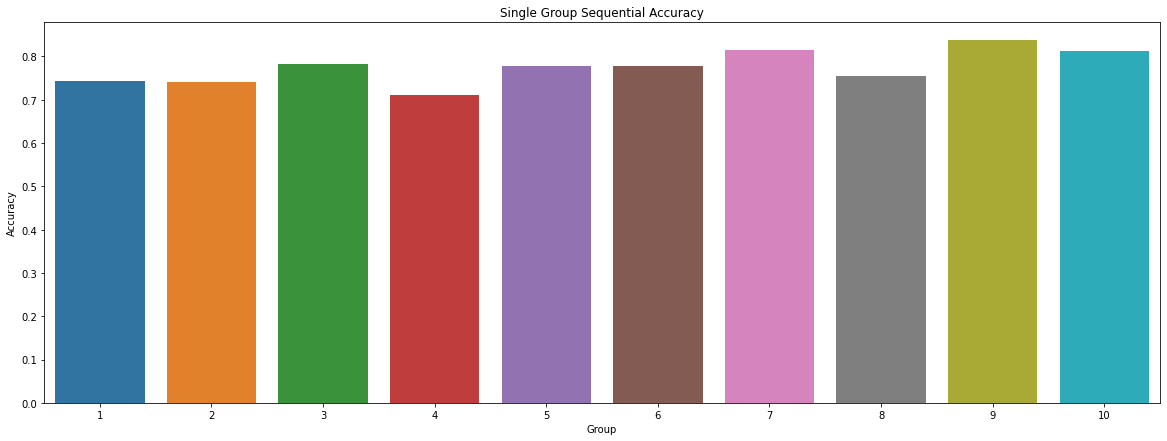

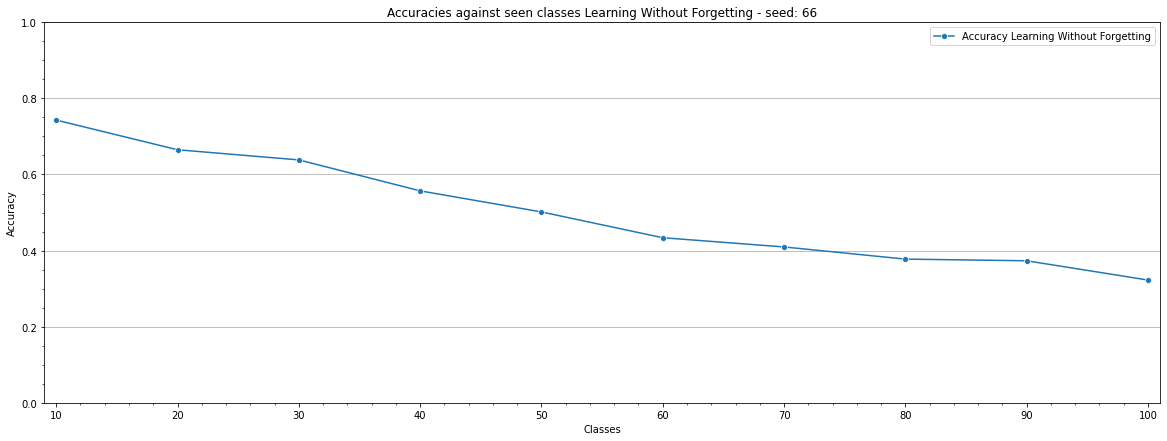

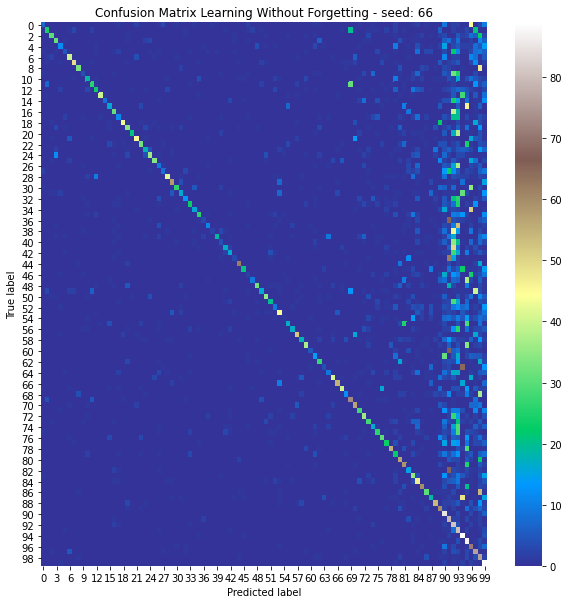

NameError: ignored

In [25]:
method = "Learning Without Forgetting"
print("metrics FINETUNING for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,10):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)

##CLOSED AND OPEN WORLD

In [ ]:
#Dataset divided into 2 halves, 50 for closed 50 for open (choose five different random division)
#1) closed world
#  1.1)without rejection -> standard incremental scenario (train and test using selected 10 classes) but with 50 classes
#      iter = 0 -> 10 or 20 (he does so in BDOC) classes ? ask Dario
#      next iters -> add 10 until 50
#      result expected -> equal to incremental 
#
#  1.2)with rejection -> same procedure of above but we implement a rejection technique that 
#      classify as unknown an object that doesn't belong to the classes seen in the training (for the alg follow BDOC)
#      result expected -> idealistic the model should not reject any of the object because we've tested the model with classes seen in the training
#
#2) open world
#    at each step -> test the model only on unknown samples (the second half of dataset)
#    
#    result expected -> idealist the model should reject all of the test objects

###download and dividing dataset

In [ ]:
# Import dataset and apply transformations 
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# Check datasets length 
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [ ]:
#closed and open world
splits_of_10 = train_dataset.split_in_train_val_groups(ratio=0.99, seed=RANDOM_SEED)
#first 5 splits to closed world
closed = {k:splits_of_10[k] for k in range(5)}

#last 5 to open (removing the train val splits)
open = []
for k in range(5,10):
  for j in["train", "val"]:
    open += splits_of_10[k][j]

### Closed world without rejection

In [ ]:
# Reverse indexing for closed world
outputs_labels_mapping = ReverseIndex(train_dataset, closed)
print(outputs_labels_mapping.getGroups())

# TEST split
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

Int64Index([0, 1, 2, 3, 4], dtype='int64')


In [ ]:
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    val_subsets.append(val_subs)

for i in range(0,5):
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

In [ ]:
def sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets):
    net, criterion, optimizer, scheduler = getResNet32()
    test_set = None
    groups_accuracies=[]
    all_accuracies=[]
    group_id=1

    K = 2000
    iterations = 5
    num_classes = 10
    exemplars_set_tot = {new_list: [] for new_list in range(100)}
    labels_train = []
    total_classes_seen = []

    for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
      
      train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)

      print("TRAIN: ", len(train_subset))
      if test_set is None:
        test_set = test_subset
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      else:
        test_set = joinSubsets(test_dataset, [test_set, test_subset])
        old_net = copy.deepcopy(net)
        old_net.to(DEVICE)
        addOutputs(net,10)
      
      print("TEST SET LENGHT: ", len(test_set))
      print("TEST CURRENT GROUP SET LENGHT: ", len(test_subset))
      num_classes_per_group = 10
      num_classes_seen = group_id*10

      test_classes = list(test_dataset.df.loc[test_set.indices, 'labels'].value_counts().index)
      train_classes = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
      validation_classes = list(train_dataset.df.loc[val_subset.indices, 'labels'].value_counts().index)
      for i in train_classes:
        total_classes_seen.append(i)
      print("TEST_SET CLASSES: ", test_classes)
      print("TRAIN_SET CLASSES: ", train_classes)
      print("VALIDATION CLASSES: ", validation_classes)
      print("GROUP: ",group_id)
      # Train on current group
      optimizer, scheduler = getSchedulerOptimizer(net) # reset learning rate and step_size

      incrementalTrain(net, train_subset, criterion, optimizer, scheduler, num_classes_seen, group_id, K, exemplars_set_tot, old_net, total_classes_seen) # Train the network with 10 classes at a time

      # Validate on current group
      val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc, loss, _, _ = validate(net, val_loader, criterion, num_classes_seen)
      print("EVALUATION: ",acc, loss)

      # Test on current group
      test_group_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_group, _, _ = test(net, test_group_loader, num_classes_seen)
      groups_accuracies.append(acc_group)

      test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
      acc_all, all_preds_cm, all_labels_cm = test(net, test_loader, num_classes_seen)
      all_accuracies.append(acc_all)
      
      print("TEST GROUP: ",acc_group)
      print("TEST ALL: ",acc_all)
      group_id+=1

    return net, groups_accuracies, all_accuracies, all_preds_cm, all_labels_cm

def printAccuracyDifference(net, old_accuracies):
    dif_accuracies=[]
    id_group=0
    for test_subset in test_subsets:
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=False)
        acc = test(net, test_loader)
        dif_accuracies.append((id_group+1,old_accuracies[id_group],acc))
        id_group+=1
    return dif_accuracies

In [ ]:
# train
net, old_accuracies, new_accuracies, all_preds_cm, all_labels_cm = sequentialLearningiCaRL(train_subsets, val_subsets, test_subsets)

In [ ]:
method = "Closed world without Rejection"
print("metrics ClosedWord for seed {}".format(RANDOM_SEED))

data_plot_bar=[]
data_plot_line=[]
for id in range(0,5):
    data_plot_bar.append((id+1,old_accuracies[id]))
    data_plot_line.append(((id+1)*10,new_accuracies[id]))

plt.figure(figsize=(20,7))
accuracyDF=pd.DataFrame(data_plot_bar, columns = ['Group','Accuracy'])
ax = sns.barplot(x="Group", y="Accuracy",data=accuracyDF)
plt.title("Single Group Sequential Accuracy")
plt.show()

# plot accuracy trend
plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write down json
writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)